# Import Dependencies

In [ ]:
import os
import random
random_state = int(random.random()*1e9)

import torch
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore', category=ConvergenceWarning)

import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-1]))
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

from tensor_completion_models.ETC import ETC
from tensor_completion_models.utils import *
from tensor_completion_models.ensemble_costco import ensemble_costco as EnT

# Data

### Load Data

In [ ]:
data_folder = 'data/'

In [ ]:
dataset = 'lattice'
# dataset = 'crossed_barrel'
# dataset = 'cogni_spin'

if dataset == 'lattice':
    df = pd.read_csv(f'{data_folder}database_latticedesign.csv')
    features = ['lattice_type', 't', 'uc_x1', 'uc_x2', 'uc_x3']

    targets = [
        'E (MPa)',
        'E_specific (MPa/g)'
        ]

    if len(targets) > 1:
        df_list = list()
        for t in range(len(targets)): 
            sub_df = df[features + [targets[t]]].to_numpy()
            sub_df = np.concatenate((t*np.ones((sub_df.shape[0], 1)), 
                                    sub_df), 
                                    axis = 1)

            df_list.append(sub_df)

        target = 'target'
        df = pd.DataFrame(np.concatenate(df_list), columns = ['task'] + features + [target])
        features = [x for x in list(df.columns) if x != target]
    else:
        target = targets[0]
        df = df[features + [target]]

elif dataset == 'crossed_barrel':
    df = pd.read_csv(f'{data_folder}crossed_barrel_dataset_v2.csv')
    features = ['n', 'theta', 'r', 't']
    targets = ['toughness']
    target = targets[0]
    df = df[features + [target]]
    df = df.groupby(features, as_index=False).agg(target=(target, 'median'))
    target = 'target'
    
elif dataset.lower() == 'cogni_spin':
    df = pd.read_csv(f'{data_folder}Cogni-e-SpinDB 1.0.csv')

    features = ['solution_concentration', 'voltage_kv', 'flow_rate_ml/h', 'tip_collector_distance_cm',
                'polymer(s)']
    # features += ['needle_diameter_g']  # ~50% missing values!

    target = 'fiber_diameter_nm'

    df = df[df['polymer(s)'].map(lambda x: x in ['PVDF', 'PVA', 'PAN'])]
    codes, uniques = pd.factorize(df["polymer(s)"])
    df['polymer(s)'] = codes

    df = df[features + [target]].dropna()

    mask = (df['flow_rate_ml/h'] < 5) & (df['tip_collector_distance_cm'] < 45) & (df['voltage_kv'] < 40)
    df = df[mask]

original_features = copy.deepcopy(features)

In [4]:
df = (
    df.groupby(features, as_index=False)
    .agg(
        value_mean=(target, 'mean'),
        target_std=(target, 'std'),
        target_min=(target, 'min'),
        target_max=(target, 'max'),
        num_duplicates=(target, 'count')
    )
)

df['target_std'] = df['target_std'].fillna(0)
df.columns = [x if x != 'value_mean' else target for x in df.columns]

df = df[df['target_std'] == 0]

df = df[df.columns[:-4]]

# df.sort_values(by='target_std', ascending=False).head(10)

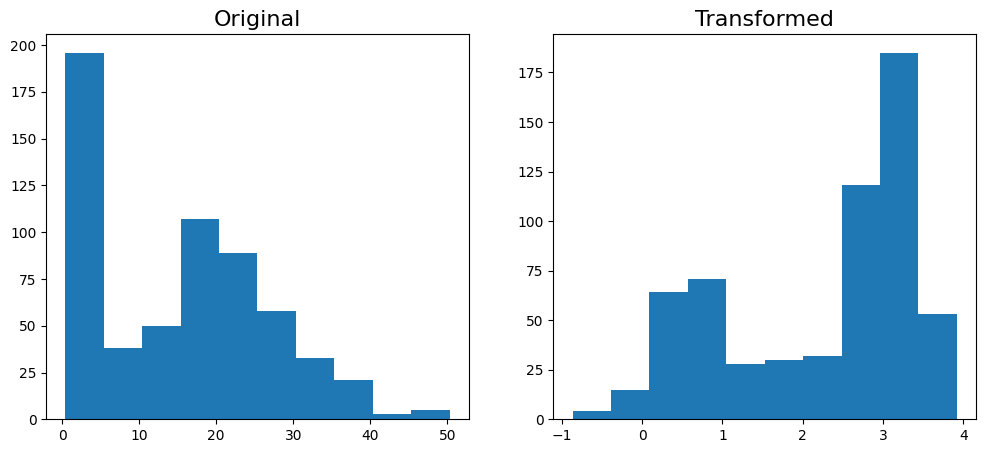

In [5]:
t = 'none' if dataset == 'cogni_spin' else 'log'

ts = {
    'none': lambda x: x,
    'log': lambda x: np.log(x),
    'sqrt': lambda x: np.sqrt(x),
    'loglog': lambda x: np.log( np.log(x) )
}
t = ts[t]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(df[target])
axes[0].set_title('Original', fontsize = 16)

axes[1].hist(t(df[target]))
axes[1].set_title('Transformed', fontsize = 16)

plt.show()

df[target] = t(df[target])

In [6]:
round_ = None

if type(round_) in [float, int]: round_ = {feature:round_ for feature in features}
elif round_ is not None:
    for feature in features:
        if feature not in round_: round_[feature] = round_['default']

tensor_df = df.copy()
master_conv, r_master_conv = dict(), dict()
for feature in features:
    if round_ is not None: unique = (tensor_df[feature]//round_[feature]).unique()
    else: unique = tensor_df[feature].unique()

    unique = np.sort(unique)

    conv = {unique[i]:i for i in range(len(unique))}
    master_conv[feature] = conv

    r_conv = {i:unique[i] for i in range(len(unique))}
    r_master_conv[feature] = r_conv

    if round_ is not None: tensor_df[feature] = (tensor_df[feature]//round_[feature]).map(lambda x: conv[x])
    else: tensor_df[feature] = tensor_df[feature].map(lambda x: conv[x])

tensor_shape = torch.Size([tensor_df[feature].max()+1 for feature in features])
print(tensor_shape)

torch.Size([4, 9, 11, 3])


In [7]:
indices = tensor_df[features].to_numpy()
indices = torch.tensor(indices, dtype = torch.int32)
values = torch.tensor(tensor_df[target].to_numpy())

sparse_tensor = torch.sparse_coo_tensor(indices = indices.t(), 
                                        values = values, 
                                        size = tensor_shape
                                       ).coalesce()

In [8]:
def one_hot_encode(df, col):
    dummies = pd.get_dummies(df[col], prefix=col)
    r_df = pd.concat([dummies.astype(int), df.drop(columns=[col])], axis=1)
    r_df = r_df[[c for c in r_df.columns if c != target] + [target]]
    return r_df

if dataset == 'lattice': df = one_hot_encode(df, 'lattice_type')
if dataset == 'cogni_spin' and 'polymer(s)' in df.columns: df = one_hot_encode(df, 'polymer(s)')
features = [x for x in df.columns if x != target]

### Setup Sampling

In [9]:
n_splits = 5

In [10]:
fm = lambda x, y = 6: " "*(y-len(str(x))) + str(x)
for f in [c for c in tensor_df.columns if c != target]: 
    print(f"{fm(f, y = 12 if dataset == 'lattice' else 6)}: {sorted(tensor_df[f].unique())}")

     n: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
 theta: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
     r: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]
     t: [np.int64(0), np.int64(1), np.int64(2)]


In [11]:
if dataset == 'lattice':

    n_in,  n_out = 50, 5
    c1 = 'lattice_type'
    c2 = 't'
    # condition = ((tensor_df[c1] == 0) | (tensor_df[c1] == 1)) & (tensor_df[c2] == 1)

    c1_low, c1_high = 0, 1
    c2_low, c2_high = 1, 1
    condition = (tensor_df[c1] >= c1_low) & (tensor_df[c1] <= c1_high) & (tensor_df[c2] >= c2_low) & (tensor_df[c2] <= c2_high)

if dataset == 'crossed_barrel':

    n_in,  n_out = 150, 75
    # n_in,  n_out = 100, 25
    c1 = 'n'
    c2 = 't'
    # condition = (tensor_df[c1] <= 1) & (tensor_df[c2] == 1)

    c1_low, c1_high = 0, 1
    c2_low, c2_high = 1, 2
    condition = (tensor_df[c1] >= c1_low) & (tensor_df[c1] <= c1_high) & (tensor_df[c2] >= c2_low) & (tensor_df[c2] <= c2_high)

if dataset == 'cogni_spin':

    # n_in,  n_out = 75, 35
    n_in, n_out = 140, 40
    c1 = 'flow_rate_ml/h'
    c2 = 'voltage_kv'

    c1_low, c1_high = 0, 8
    c2_low, c2_high = 10, 18
    condition = (tensor_df[c1] >= c1_low) & (tensor_df[c1] <= c1_high) & (tensor_df[c2] >= c2_low) & (tensor_df[c2] <= c2_high)

train_test_splits = list()
for _ in range(n_splits):

    df1 = df[condition]
    df2 = df[~condition]
    if _ == 0: print(df1.shape[0], df2.shape[0], '\n')

    df1_i = list(df1.index)
    df2_i = list(df2.index)

    random_seed = int(100_000 * random.random())
    print(f"Random Seed = {random_seed}")
    random.seed(random_seed)
    random.shuffle(df1_i)
    random.shuffle(df2_i)

    train_i = df1_i[:n_in]  + df2_i[:n_out]
    test_i = df1_i[n_in:]  + df2_i[n_out:]

    # ________________________________________________________________________________________________________________

    train_df = df.loc[train_i].sample(frac = 1, random_state = random_state).reset_index(drop = True)
    test_df = df.loc[test_i].sample(frac = 1, random_state = random_state).reset_index(drop = True)
    X_train = train_df[[c for c in train_df.columns if c != target]].to_numpy()
    Y_train = train_df[target].to_numpy()

    X_test = test_df[[c for c in train_df.columns if c != target]].to_numpy()
    Y_test = test_df[target].to_numpy()
    
    X = np.concatenate((X_train, X_test))
    X_train = (X_train - X.min(axis = 0)) / (X.max(axis = 0) - X.min(axis = 0))
    X_test = (X_test - X.min(axis = 0)) / (X.max(axis = 0) - X.min(axis = 0))
    del X

    Y_test = (Y_test - Y_train.min()) / (Y_train.max() - Y_train.min())
    Y_train = (Y_train - Y_train.min()) / (Y_train.max() - Y_train.min())

    # ________________________________________________________________________________________________________________

    tensor_train_df = tensor_df.loc[train_i].sample(frac = 1, random_state = random_state).reset_index(drop = True)
    tensor_test_df = tensor_df.loc[test_i].sample(frac = 1, random_state = random_state).reset_index(drop = True)

    tFeatures = [c for c in tensor_test_df.columns if c != target]

    tX_train = torch.tensor(tensor_train_df[tFeatures].to_numpy(), dtype = torch.int32).t()
    tX_test = torch.tensor(tensor_test_df[tFeatures].to_numpy(), dtype = torch.int32).t()

    tY_train = torch.tensor(tensor_train_df[target].to_numpy())
    tY_test = torch.tensor(tensor_test_df[target].to_numpy())

    tY_test = (tY_test - tY_train.min()) / (tY_train.max() - tY_train.min())
    tY_train = (tY_train - tY_train.min()) / (tY_train.max() - tY_train.min())

    training_sparse_tensor = torch.sparse_coo_tensor(indices = tX_train,
                                                     values = tY_train, 
                                                     size = tensor_shape
                                                     ).coalesce()

    testing_sparse_tensor = torch.sparse_coo_tensor(indices = tX_test, 
                                                    values = tY_test, 
                                                    size = tensor_shape
                                                    ).coalesce()

    # ________________________________________________________________________________________________________________

    if dataset == 'cogni_spin':
        train_test_splits = [{
            'ML':(X_train, X_test, Y_train, Y_test),
            'Tensor':(training_sparse_tensor, testing_sparse_tensor),
            'tensor_df':(tensor_train_df, tensor_test_df)
            }] * n_splits
        break
    else:
        train_test_splits.append({
            'ML':(X_train, X_test, Y_train, Y_test),
            'Tensor':(training_sparse_tensor, testing_sparse_tensor),
            'tensor_df':(tensor_train_df, tensor_test_df)
        })

200 400 

Random Seed = 35176
Random Seed = 3701
Random Seed = 6008
Random Seed = 85129
Random Seed = 96303


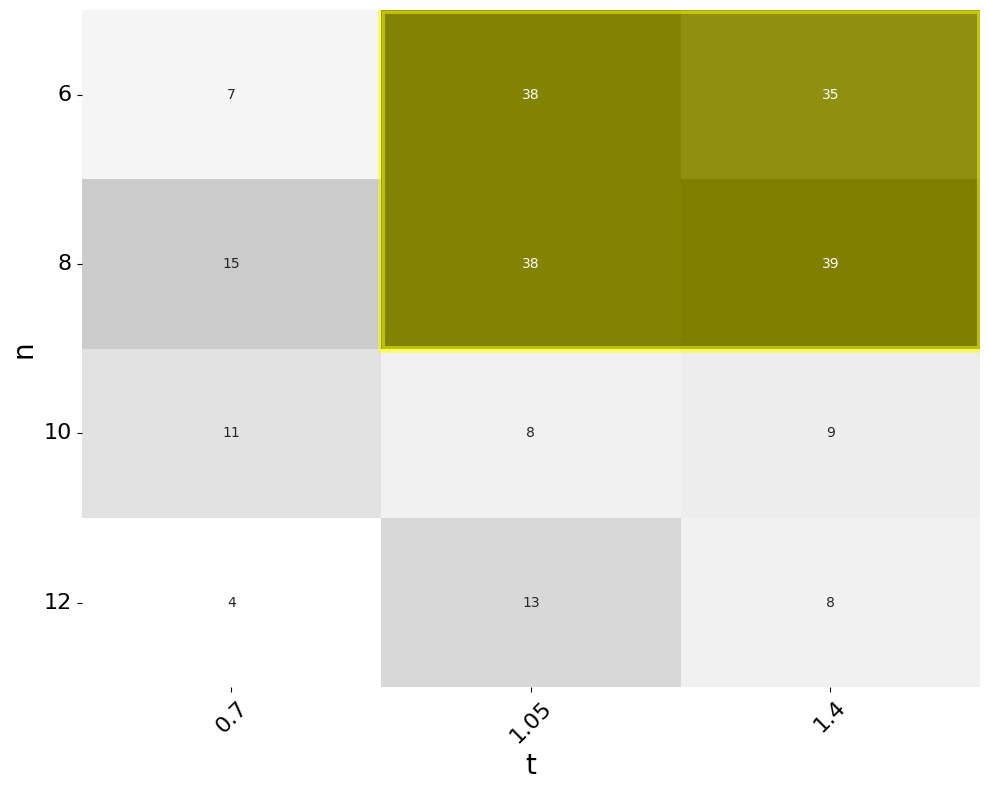

In [12]:
import matplotlib.patches as patches
c1_all = sorted(r_master_conv[c1].keys())
c2_all = sorted(r_master_conv[c2].keys())

tensor_train_df = train_test_splits[1]['tensor_df'][0]

# Crosstab on observed data, then expand to full grid
crosstab = pd.crosstab(tensor_train_df[c1], tensor_train_df[c2])
# crosstab = pd.crosstab(tensor_df[c1], tensor_df[c2])

crosstab = crosstab.reindex(index=c1_all, columns=c2_all, fill_value=0)

# full ordered index sets used by the heatmap
c1_all = list(crosstab.index)
c2_all = list(crosstab.columns)

# find index ranges (inclusive)
c1_lo_idx = min(i for i, v in enumerate(c1_all) if v >= c1_low)
c1_hi_idx = max(i for i, v in enumerate(c1_all) if v <= c1_high)

c2_lo_idx = min(i for i, v in enumerate(c2_all) if v >= c2_low)
c2_hi_idx = max(i for i, v in enumerate(c2_all) if v <= c2_high)

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    crosstab,
    annot=True, fmt='d',
    cmap='Grays',
    cbar=False,
    ax=ax
)

# rectangle: (x, y, width, height)
rect = patches.Rectangle(
    (c2_lo_idx, c1_lo_idx),
    (c2_hi_idx - c2_lo_idx + 1),
    (c1_hi_idx - c1_lo_idx + 1),
    linewidth=5,
    edgecolor='yellow',
    facecolor='yellow',
    alpha = 0.5
)

ax.add_patch(rect)

ax.set_xlabel(c2, fontsize=20)
ax.set_ylabel(c1, fontsize=20)

ax.set_xticklabels(sorted(r_master_conv[c2].values()), rotation = 45, fontsize = 16)
ax.set_yticklabels(sorted(r_master_conv[c1].values()), rotation = 0, fontsize = 16)

plt.tight_layout()
plt.show()

# Experiments

### Experiment

In [13]:
def get_results():
    it_list = list()
    pred_it_list = list()
    tensor_test_df_list = list()

    print("Iteration:", end = " ")
    for it in range(1, len(train_test_splits)+1):

        train_test_split = train_test_splits[it-1]

        random_state = int(random.random()*100_000)
        training_sparse_tensor, testing_sparse_tensor = train_test_split['Tensor']
        X_train, X_test, Y_train, Y_test = train_test_split['ML']
        tensor_test_df_list.append(train_test_split['tensor_df'][1])

        metric_list = list()
        pred_list = list()

        # ________________________________________________________________________________________________________________________

        ent = EnT(tensor_shape = tensor_shape,
                  rank = {'lattice':5, 'crossed_barrel':32, 'cogni_spin':28}[dataset],
                  activation = 'relu',
                  dropout = [0.2, 0],
                  hidden_channels = 7,
                  n_decompositions = 10)

        ent.train_model(training_sparse_tensor.indices().t(),
                        training_sparse_tensor.values(),
                        validation_portion = 0,
                        early_stopping = 0,
                        n_epochs = 250, 
                        lr = 5e-3, 
                        wd = 5e-3,
                        batch_size = 96,
                        print_rate = 100, 
                        verbose = False)

        preds = ent(testing_sparse_tensor.indices().t()).detach().cpu().numpy()
        r2 = r2_score(testing_sparse_tensor.values(), preds)
        mae = abs(preds - testing_sparse_tensor.values().numpy()).mean()
        metric_list.append([r2, mae])
        pred_list.append([preds, testing_sparse_tensor.values()])
        del ent, preds, r2, mae

        # ________________________________________________________________________________________________________________________

        model = train_tensor_completion(model_type = 'NeAT',
                                        rank = 32,
                                        lr = 1e-3,
                                        wd = 1e-4,
                                        sparse_tensor = training_sparse_tensor,
                                        num_epochs = 500,
                                        batch_size = 96,
                                        loss_p = 2,
                                        NeAT_hidden_dim = 64,
                                        NeAT_drop = 0.2,
                                        NeAT_drop2 = 0.8,
                                        val_size = None,
                                        early_stopping = False,
                                        verbose = False)

        preds = model(testing_sparse_tensor.indices().t()).detach().cpu().numpy()
        r2 = r2_score(testing_sparse_tensor.values(), preds)
        mae = abs(preds - testing_sparse_tensor.values().numpy()).mean()
        metric_list.append([r2, mae])
        pred_list.append([preds, testing_sparse_tensor.values()])
        del model, preds, r2, mae

        # ________________________________________________________________________________________________________________________

        model = train_tensor_completion(model_type = 'cpd.smooth',
                                        rank = 6,
                                        lr = 1e-3,
                                        wd = 1e-4,
                                        sparse_tensor = training_sparse_tensor,
                                        num_epochs = 500,
                                        batch_size = 96,
                                        loss_p = 1,
                                        val_size = None,
                                        early_stopping = False,
                                        verbose = False)

        preds = model(testing_sparse_tensor.indices().t()).detach().cpu().numpy()
        r2 = r2_score(testing_sparse_tensor.values(), preds)
        mae = abs(preds - testing_sparse_tensor.values().numpy()).mean()
        metric_list.append([r2, mae])
        pred_list.append([preds, testing_sparse_tensor.values()])
        del model, preds, r2, mae

        # ________________________________________________________________________________________________________________________

        model = train_tensor_completion(model_type = 'cpd',
                                        rank = 6,
                                        lr = 1e-3,
                                        wd = 1e-4,
                                        sparse_tensor = training_sparse_tensor,
                                        num_epochs = 500,
                                        batch_size = 96,
                                        loss_p = 1,
                                        val_size = None,
                                        early_stopping = False,
                                        verbose = False)

        preds = model(testing_sparse_tensor.indices().t()).detach().cpu().numpy()
        r2 = r2_score(testing_sparse_tensor.values(), preds)
        mae = abs(preds - testing_sparse_tensor.values().numpy()).mean()
        metric_list.append([r2, mae])
        pred_list.append([preds, testing_sparse_tensor.values()])
        del model, preds, r2, mae

        # ________________________________________________________________________________________________________________________

        xgb = XGBRegressor(n_estimators = 100,
                           max_depth = None,
                           random_state = random_state)

        xgb.fit(X_train, Y_train)
        preds = xgb.predict(X_test)
        r2 = r2_score(Y_test, preds)
        mae = abs(preds - Y_test).mean()
        metric_list.append([r2, mae])
        pred_list.append([preds, Y_test])
        del xgb, preds, r2, mae

        # ________________________________________________________________________________________________________________________

        catb = CatBoostRegressor(iterations = 250,
                                learning_rate = 5e-2,
                                depth = 16,
                                loss_function = 'RMSE',
                                random_state = random_state,
                                verbose = False)

        catb.fit(X_train, Y_train)
        preds = catb.predict(X_test)
        r2 = r2_score(Y_test, preds)
        mae = abs(preds - Y_test).mean()
        metric_list.append([r2, mae])
        pred_list.append([preds, Y_test])
        del catb, preds, r2, mae

        # ________________________________________________________________________________________________________________________

        kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2)) + WhiteKernel(1e-3, (1e-5, 1e1))
        gp = GaussianProcessRegressor(kernel = kernel, 
                                      alpha = 1e-6, 
                                      n_restarts_optimizer = 3, 
                                      random_state = random_state)

        gp.fit(X_train, Y_train)
        preds = gp.predict(X_test)
        r2 = r2_score(Y_test, preds)
        mae = abs(preds - Y_test).mean()
        metric_list.append([r2, mae])
        pred_list.append([preds, Y_test])
        del gp, preds, r2, mae

        # ________________________________________________________________________________________________________________________

        rf = RandomForestRegressor(n_estimators = 100, 
                                   max_depth = None, 
                                   random_state = random_state)

        rf.fit(X_train, Y_train)
        preds = rf.predict(X_test)
        r2 = r2_score(Y_test, preds)
        mae = abs(preds - Y_test).mean()
        metric_list.append([r2, mae])
        pred_list.append([preds, Y_test])
        del rf, preds, r2, mae

        # ________________________________________________________________________________________________________________________

        metric_list = np.stack(metric_list)

        it_list.append(metric_list)
        pred_it_list.append(pred_list)

        if it == len(train_test_splits): print(it)
        else: print(it, end = ', ')

    it_list = np.stack(it_list)
    pred_it_list = np.stack(pred_it_list)
    
    return it_list, pred_it_list, tensor_test_df_list

### Show Progress

In [14]:
it_list, pred_it_list, tensor_test_df_list = get_results()

Iteration: 1, 2, 3, 4, 5


### Results

In [15]:
fm = lambda x, y = 10: " " * (y - len(str(x))) + str(x)
models = ['CoSTCo', 'NeAT', 'CPD-S', 'CPD', 'XGBoost', 'CatBoost', 'GP', 'RF']
for i in range(len(models)): print(f"{fm(models[i])}: {it_list[:, i, 0].mean():.3f} ± {it_list[:, i, 0].std():.2f}")
print('_'*27, '\n')
for i in range(len(models)): print(f"{fm(models[i])}: {it_list[:, i, 1].mean():.3f} ± {it_list[:, i, 0].std():.2f}")

    CoSTCo: 0.582 ± 0.06
      NeAT: 0.395 ± 0.01
     CPD-S: 0.349 ± 0.03
       CPD: 0.199 ± 0.08
   XGBoost: 0.537 ± 0.04
  CatBoost: 0.568 ± 0.03
        GP: 0.675 ± 0.04
        RF: 0.587 ± 0.03
___________________________ 

    CoSTCo: 0.126 ± 0.06
      NeAT: 0.176 ± 0.01
     CPD-S: 0.160 ± 0.03
       CPD: 0.180 ± 0.08
   XGBoost: 0.126 ± 0.04
  CatBoost: 0.142 ± 0.03
        GP: 0.119 ± 0.04
        RF: 0.127 ± 0.03


In [16]:
models_colors = {
    'CoSTCo':'limegreen', 
    'NeAT':'magenta', 
    'CPD-S':'orangered', 
    'CPD':'deepskyblue', 
    'XGBoost':'slategray', 
    'CatBoost':'slategray',
    'GP':'slategray', 
    'RF':'slategray'
    }

models = list(models_colors)
colors = list(models_colors.values())

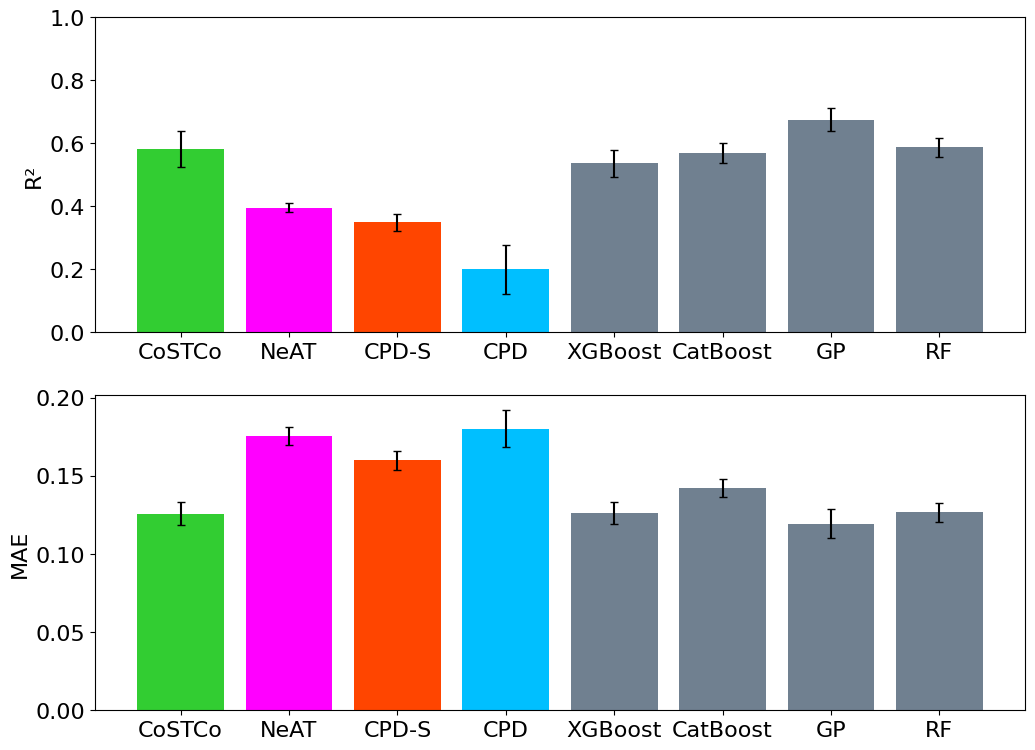

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(12, 9))

for i in range(2):
    x_positions = np.arange(it_list.shape[1])

    axes[i].bar(x_positions, it_list.mean(axis = 0)[..., i], yerr = it_list.std(axis = 0)[..., i], 
              color = colors, capsize = 3)

    axes[i].set_ylim(bottom = 0)
    if not i: axes[i].set_ylim(top = 1 if dataset == 'lattice' else 1)
    if not i: axes[i].set_ylim(bottom = 0.5 if dataset == 'lattice' else 0)

    axes[i].set_xticks(ticks = x_positions, labels = models, fontsize = 16)
    axes[i].tick_params(axis='y', labelsize = 16)

    axes[i].set_ylabel('MAE' if i else 'R²', fontsize = 16)

# axes[0].axhline(it_list.mean(axis = 0).max(axis = 0)[0], color = 'black', lw = 2, ls = '--', zorder = 0)
# axes[1].axhline(it_list.mean(axis = 0).min(axis = 0)[1], color = 'black', lw = 2, ls = '--', zorder = 0)

plt.show()

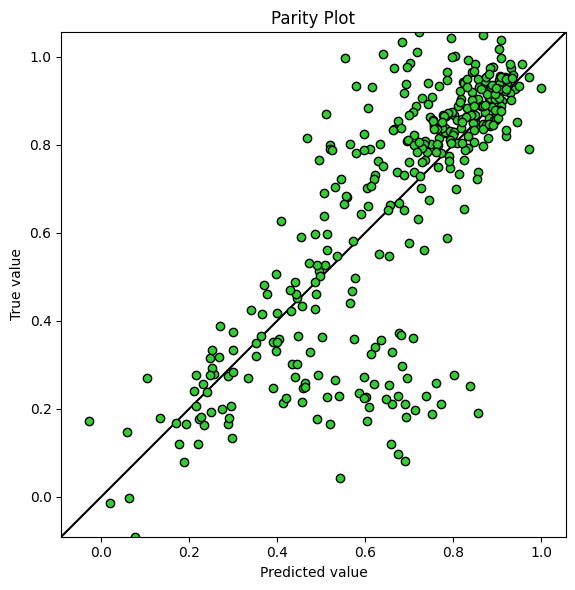

In [18]:
it_i = 0
model_i = 0

yh, y = pred_it_list[it_i][model_i]

plt.figure(figsize=(6, 6))

plt.scatter(yh, y, color='limegreen', edgecolors='black')

lims = [min(np.min(yh), np.min(y)), max(np.max(y), np.max(yh))]

plt.plot(lims, lims, linestyle='-', color = 'black', zorder = 0)
plt.xlim(lims)
plt.ylim(lims)

plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.title("Parity Plot")

plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

In [19]:
def make_heatmap_comparison(it_list = None, model_i_list = [0, 6], use_p = False, cbar_range = None, std_cbar_range = None,
                            plot_cbar = False, cell_fontsize = 10, 
                            use_mean = True):

    if cbar_range is None: m_cbar_range = (None, None)
    else: m_cbar_range = cbar_range
    
    if std_cbar_range is None: s_cbar_range = (None, None)
    else: s_cbar_range = std_cbar_range
    
    if not use_p: error_list = abs(pred_it_list[..., 0, :] - pred_it_list[..., 1, :])
    else: error_list = abs((pred_it_list[..., 0, :] - pred_it_list[..., 1, :]) / pred_it_list[..., 1, :])

    all_all_heatmap_df = list()

    its = list(range(error_list.shape[0])) if it_list is None else it_list
    for it in its:
        results_df = pd.DataFrame(tensor_test_df_list[it], columns = original_features)
        for i in range(len(models)): results_df[models[i]] = error_list[it, i, :]
        all_heatmap_df = list()
        for v1 in sorted(results_df[c1].unique()):
            all_heatmap_df_row = list()
            for v2 in sorted(results_df[c2].unique()):
                mdf = results_df[(results_df[c1] == v1) & (results_df[c2] == v2)]        
                all_heatmap_df_row.append(mdf[models].mean(axis = 0).to_numpy())
            all_heatmap_df.append(all_heatmap_df_row)
        all_heatmap_df = np.stack(all_heatmap_df)
        all_all_heatmap_df.append(all_heatmap_df)
    all_all_heatmap_df = np.stack(all_all_heatmap_df)
    all_heatmap_df_mean = all_all_heatmap_df.mean(axis = 0) 
    all_heatmap_df_std = all_all_heatmap_df.std(axis = 0)
    del all_all_heatmap_df, all_heatmap_df

    c1_all = sorted(master_conv[c1].values())
    c2_all = sorted(master_conv[c2].values())

    fig, axes = plt.subplots(2, len(model_i_list), figsize=(int(10*len(model_i_list)), 28),
                            sharey = True, sharex = True)

    for di in range(2):
        all_heatmap_df = [all_heatmap_df_mean, all_heatmap_df_std][di]
        all_vals = []
        for i in range(len(model_i_list)):
            model_i = model_i_list[i]
            crosstab = pd.DataFrame(all_heatmap_df[..., model_i])
            crosstab = crosstab.reindex(index=c1_all, columns=c2_all, fill_value = np.nan)
            all_vals.append(crosstab.values)

        global_min = np.min(all_vals)
        global_max = np.max(all_vals)

        for i in range(len(model_i_list)):
            model_i = model_i_list[i]
            ax = axes[di, i]

            crosstab = pd.DataFrame(all_heatmap_df[..., model_i])
            crosstab = crosstab.reindex(index=c1_all, columns=c2_all, fill_value = np.nan)

            c1_all = list(crosstab.index)
            c2_all = list(crosstab.columns)

            cmap = mpl.colormaps["RdYlGn_r"].copy()
            cmap.set_bad(color="lightgray")

            t_cbar_range = [m_cbar_range, s_cbar_range][di]
            hm = sns.heatmap(
                crosstab.round(3),
                annot = True,
                annot_kws = {"size": cell_fontsize},
                cmap = cmap,
                cbar= i==len(model_i_list)-1 and plot_cbar,
                ax = ax,
                vmin = global_min if t_cbar_range[0] is None else t_cbar_range[0],
                vmax = global_max if t_cbar_range[1] is None else t_cbar_range[1]
            )

            if hm.collections[0].colorbar is not None:
                cbar = hm.collections[0].colorbar
                cbar.ax.tick_params(labelsize=64)

            if i == 0: ax.set_ylabel(' '.join(c1.split('_')), fontsize = 64)
            if di == 1: ax.set_xlabel(' '.join(c2.split('_')), fontsize = 64)
            
            ax.set_xticklabels(sorted(master_conv[c2].keys()), rotation = 90, fontsize = 64)
            ax.set_yticklabels(sorted(master_conv[c1].keys()), rotation = 0, fontsize = 64)

            ax.set_title(f"{models[model_i]} ({['Mean', 'Std. Dev.'][di]})", fontsize = 72)

            rect = patches.Rectangle(
                (c2_lo_idx, c1_lo_idx),
                (c2_hi_idx - c2_lo_idx + 1),
                (c1_hi_idx - c1_lo_idx + 1),
                linewidth=5,
                edgecolor='black',
                facecolor = 'black',
                fill = False,
                alpha = 1
            )

            ax.add_patch(rect)
            rect.set_clip_on(False)

    plt.tight_layout()
    plt.show()

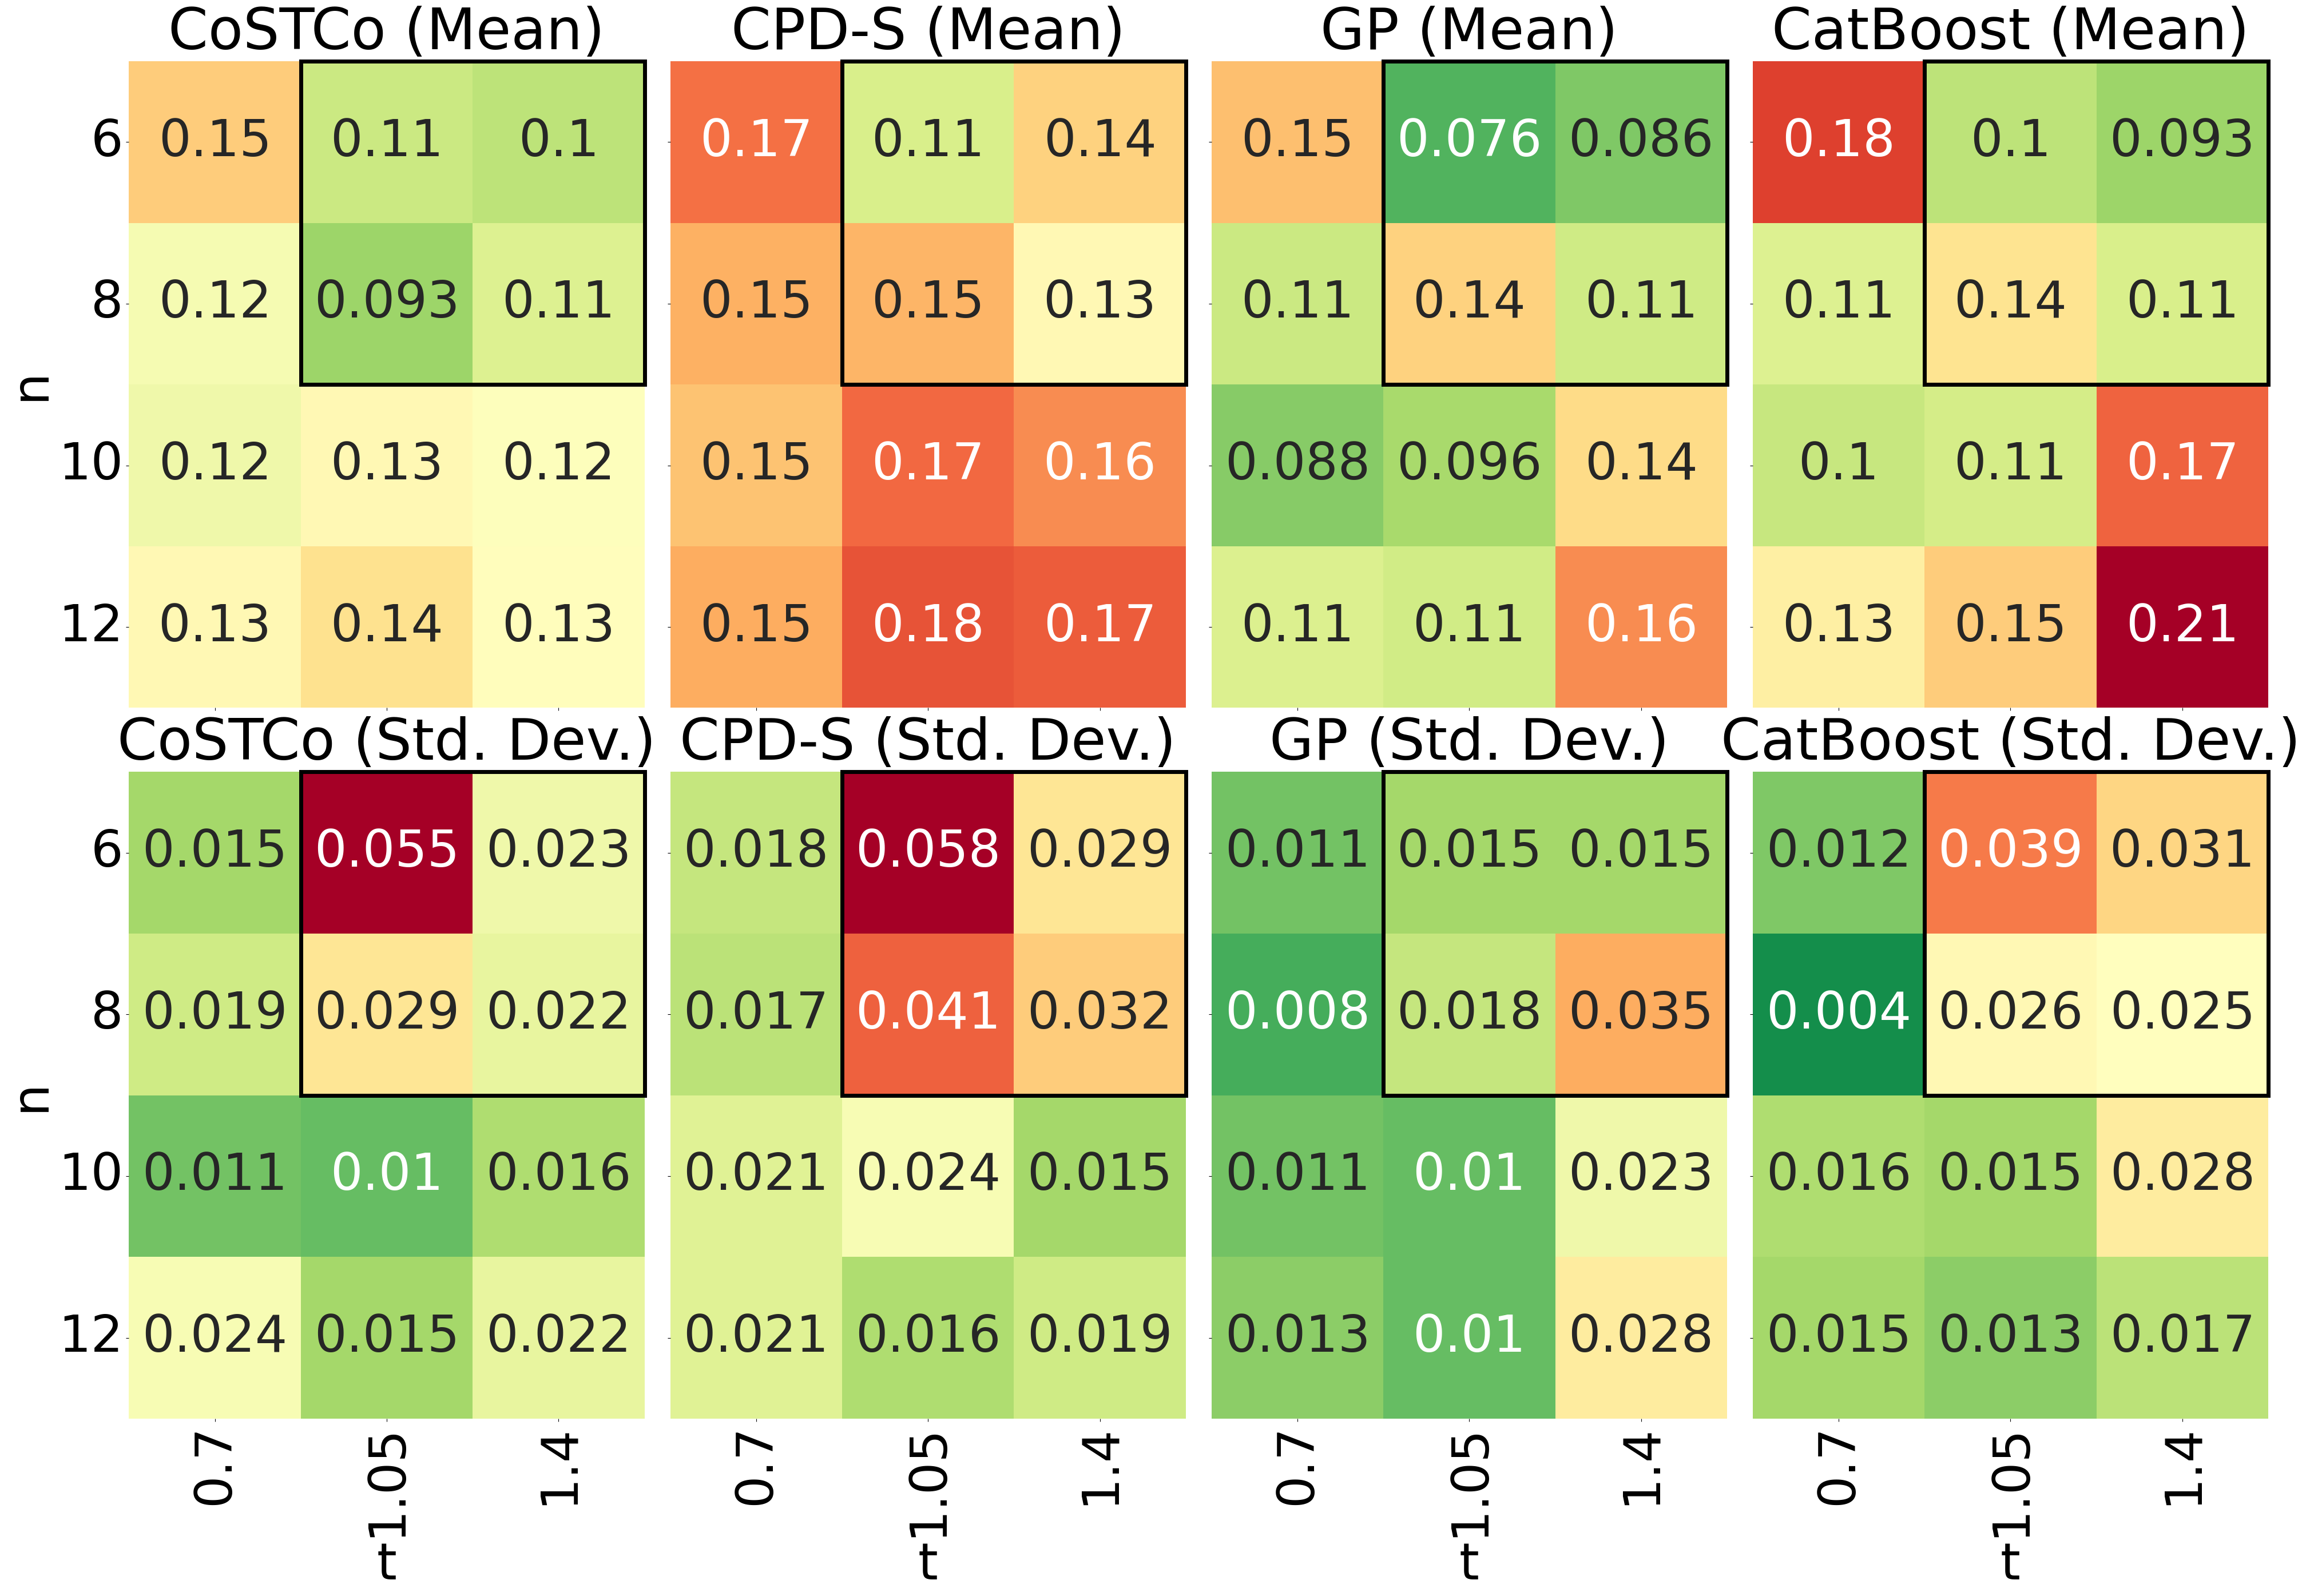

In [20]:
show_std = 0
make_heatmap_comparison(it_list = None,
                        model_i_list = [0, 2, 6, 5],
                        use_p = False,
                        # cbar_range = (0.1, 0.25),
                        # cbar_range = (0.01, 0.05) if show_std else (0.05, 0.2),
                        # cbar_range = None,
                        cbar_range = (0.05, 0.2),
                        # std_cbar_range = (0, 0.075),
                        std_cbar_range = (0, 0.05),
                        plot_cbar = False,
                        cell_fontsize = 64 if dataset != 'cogni_spin' else 10,
                        use_mean = not show_std)

In [21]:
# def make_heatmap_comparison(it_list = None, model_i_list = [0, 6], use_p = False, cbar_range = None, plot_cbar = False, cell_fontsize = 10, 
#                             use_mean = True):

#     if cbar_range is None: t_cbar_range = (None, None)
#     else: t_cbar_range = cbar_range
#     if not use_p: error_list = abs(pred_it_list[..., 0, :] - pred_it_list[..., 1, :])
#     else: error_list = abs((pred_it_list[..., 0, :] - pred_it_list[..., 1, :]) / pred_it_list[..., 1, :])

#     all_all_heatmap_df = list()
    
#     its = list(range(error_list.shape[0])) if it_list is None else it_list
#     for it in its:
#         results_df = pd.DataFrame(tensor_test_df_list[it], columns = original_features)
#         for i in range(len(models)): results_df[models[i]] = error_list[it, i, :]
#         all_heatmap_df = list()
#         for v1 in sorted(results_df[c1].unique()):
#             all_heatmap_df_row = list()
#             for v2 in sorted(results_df[c2].unique()):
#                 mdf = results_df[(results_df[c1] == v1) & (results_df[c2] == v2)]        
#                 all_heatmap_df_row.append(mdf[models].mean(axis = 0).to_numpy())
#             all_heatmap_df.append(all_heatmap_df_row)
#         all_heatmap_df = np.stack(all_heatmap_df)
#         all_all_heatmap_df.append(all_heatmap_df)
#     all_all_heatmap_df = np.stack(all_all_heatmap_df)
#     all_heatmap_df = all_all_heatmap_df.mean(axis = 0) if use_mean else all_all_heatmap_df.std(axis = 0)
#     del all_all_heatmap_df

#     c1_all = sorted(master_conv[c1].values())
#     c2_all = sorted(master_conv[c2].values())

#     fig, ax = plt.subplots(1, len(model_i_list), figsize=(int(12*len(model_i_list)), 12))

#     all_vals = []
#     for i in range(len(model_i_list)):
#         model_i = model_i_list[i]
#         crosstab = pd.DataFrame(all_heatmap_df[..., model_i])
#         crosstab = crosstab.reindex(index=c1_all, columns=c2_all, fill_value = np.nan)
#         all_vals.append(crosstab.values)

#     global_min = np.min(all_vals)
#     global_max = np.max(all_vals)

#     for i in range(len(model_i_list)):
#         model_i = model_i_list[i]

#         crosstab = pd.DataFrame(all_heatmap_df[..., model_i])
#         crosstab = crosstab.reindex(index=c1_all, columns=c2_all, fill_value = np.nan)

#         c1_all = list(crosstab.index)
#         c2_all = list(crosstab.columns)

#         cmap = mpl.colormaps["RdYlGn_r"].copy()
#         cmap.set_bad(color="lightgray")

#         hm = sns.heatmap(
#             crosstab.round(3),
#             annot = True,
#             annot_kws = {"size": cell_fontsize},
#             cmap = cmap,
#             cbar= i==len(model_i_list)-1 and plot_cbar,
#             ax = ax[i],
#             vmin = global_min if t_cbar_range[0] is None else t_cbar_range[0],
#             vmax = global_max if t_cbar_range[1] is None else t_cbar_range[1]
#         )

#         ax[i].set_xlabel(' '.join(c2.split('_')), fontsize=36)
#         ax[i].set_ylabel(' '.join(c1.split('_')), fontsize=36)

#         ax[i].set_xticklabels(sorted(master_conv[c2].keys()), rotation = 45, fontsize = 27)
#         ax[i].set_yticklabels(sorted(master_conv[c1].keys()), rotation = 0, fontsize = 27)

#         ax[i].set_title(models[model_i], fontsize = 65)

#         rect = patches.Rectangle(
#             (c2_lo_idx, c1_lo_idx),
#             (c2_hi_idx - c2_lo_idx + 1),
#             (c1_hi_idx - c1_lo_idx + 1),
#             linewidth=5,
#             edgecolor='black',
#             facecolor = 'black',
#             fill = False,
#             alpha = 1
#         )
        
#         if hm.collections[0].colorbar is not None:
#             cbar = hm.collections[0].colorbar
#             cbar.ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
#             cbar.ax.tick_params(labelsize=48)

#         ax[i].add_patch(rect)
#         rect.set_clip_on(False)

#     plt.tight_layout()
#     plt.show()